In [1]:
import numpy as np
import os
import pandas as pd
import neurokit2 as nk
from scipy.signal import find_peaks
from scipy import signal
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC, SVR, SVC

from sklearn.model_selection import train_test_split, LeaveOneOut, GroupKFold, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer, f1_score

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from sklearn.feature_selection import RFE
from sklearn.svm import SVR

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
root_directory = r"C:\Users\leagi\Documents\EI22\Projet Ecole\data\Features"
filename_ecg = "ECG_features.csv"
filename_rr = "RR_features.csv"
filename_eda = "EDA_features.csv"
filename_label = "..\labels.csv"

In [3]:
def read_feature_dataset(root_directory, feature_ecg, feature_rr, feature_eda, label):
    feature_ecg = pd.read_csv(os.path.join(root_directory, feature_ecg), sep = ";")
    feature_rr = pd.read_csv(os.path.join(root_directory, feature_rr), sep = ";")
    feature_eda = pd.read_csv(os.path.join(root_directory, feature_eda), sep = ";")
    label_df =_df = pd.read_csv(os.path.join(root_directory, label), sep = ";")

    dataframe = feature_ecg.drop(['ID','Task'], axis=1)
    dataframe = pd.concat([dataframe, feature_rr.drop(['ID','Task'], axis=1)], axis = 1)
    dataframe = pd.concat([dataframe, feature_eda.drop(['ID_Task'], axis=1)], axis = 1)
    dataframe.insert(loc=0, column = 'Stress', value = label_df['binary-stress'])
    
    return dataframe

In [4]:
def correlation_matrix(datas, fig=False):
    # Calculate the correlation matrix
    correlation_matrix = datas.corr()

    if fig:
        # Create a heatmap
        plt.figure(figsize=(30, 20))
        sns.heatmap(correlation_matrix, annot=False, fmt='.2f', annot_kws=dict(size=15), cmap='PiYG')
        plt.title('Correlation Matrix of ECG Features')
        plt.xlabel('Features')
        plt.ylabel('Features')
        plt.show()
    return correlation_matrix

In [5]:
def features_selection(matrix):
    corr_pairs=[]
    for i in range(len(matrix.columns)):
        for j in range(i):
            if matrix.iloc[i,j]>0.9:
                corr_pairs.append((matrix.columns[i],matrix.columns[j],matrix.iloc[i,j]))

    features_to_drop = []
    for i,j,k in corr_pairs:
        features_to_drop.append(j)
        
    features_to_drop = list(set(features_to_drop))
    return features_to_drop

In [6]:
def moyenne(liste):
    return sum(liste)/len(liste)

In [7]:
def conf_matrix(name_model, target, prediction, axe):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    
    cm = confusion_matrix(target, prediction)
    
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm, annot=labels, fmt='', square = True, ax=axe)
    axe.set_title('confusion matrice '+ name_model)

In [ ]:
#search the best parameters for each model in function on our features
def search_parameters(root_directory, feature_ecg, feature_rr, feature_eda, label):
    features = read_feature_dataset(root_directory, feature_ecg, feature_rr, feature_eda, label)
    
    # Remove infinite values
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.dropna(inplace=True)

    # data's separation
    inputs = features.drop('Stress',axis=1)
    target = features['Stress']


    # Define models and their respective hyperparameter grids
    param_grid = {
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=200),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs']
            }
        },
        'k-Nearest Neighbors': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
        },

        'MLP Classifier': {
            'model': MLPClassifier(max_iter=1000),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                'activation': ['tanh', 'relu'],
                'solver': ['sgd', 'adam'],
                'alpha': [0.0001, 0.05],
                'learning_rate': ['constant', 'adaptive']
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [10, 50, 100],
                'max_depth': [None, 5, 10],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
            'params': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            }
        }    
    }

    # Define the k-fold cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Initialize a list to hold the results
    results = []

    # Perform grid search cross-validation for each model
    for model_name, config in tqdm(param_grid.items()):
        grid_search = GridSearchCV(config['model'], config['params'], cv=kf, n_jobs=-1)
        grid_search.fit(inputs, target)
        
        results.append({
            'Model': model_name,
            'Best Params': grid_search.best_params_,
            'Best Score': grid_search.best_score_
        })
    
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df
    

In [ ]:
parameters=search_parameters(root_directory, filename_ecg, filename_rr, filename_eda, filename_label)
parameters

 40%|████      | 2/5 [00:16<00:22,  7.43s/it]

In [ ]:
#give the results for each model on our features
def resultats(root_directory, feature_ecg, feature_rr, feature_eda, label, selection = False):
    features = read_feature_dataset(root_directory, feature_ecg, feature_rr, feature_eda, label)
    
    # Remove infinite values
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.dropna(inplace=True)
    target = features['Stress']
    
    if(selection):
        # data's separation
        X = features.drop('Stress',axis=1)
        corr_matrix = correlation_matrix(X)
    
        #features selection
        features_to_drop = features_selection(corr_matrix)
        inputs = X.drop(features_to_drop,axis=1)
        
    else:
        inputs = features.drop('Stress',axis=1)
        

    # Define the model
    models = {'Logistic Regression': LogisticRegression(C=1, solver='liblinear', max_iter=200),
              'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance'),
              'MLP' : MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(50, 50),learning_rate='adaptive', 
                                    solver='adam', max_iter=1000),
              'Random Forest': RandomForestClassifier(bootstrap=False, max_depth=None, min_samples_leaf=2,
                                                      min_samples_split=10, n_estimators=100),
              'XGB': XGBClassifier(colsample_bytree=0.6, learning_rate=0.01, 
                                   max_depth=7, n_estimators=200, subsample=0.6, use_label_encoder=False, eval_metric='mlogloss'),
              'SVC' : SVC(gamma='auto', kernel = 'rbf')
            }

    # Define the k-fold cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Définir le F1-score comme métrique
    scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'accuracy': make_scorer(accuracy_score)}

    # Initialize a list to hold the results
    results = []

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 6), constrained_layout=True)
    i=0
    j=0

    # Perform cross-validation for each model
    for model_name, model in tqdm(models.items()):
        scores = cross_validate(model, inputs, target, cv=kf, scoring=scoring)
        y_pred = cross_val_predict(model, inputs, target, cv=kf)
        
        results.append({
            'Model': model_name,
            'Cross-validation accuracy': scores['test_accuracy'],
            'Cross-validation F1-scores': scores['test_f1_macro'],
            'Mean accuracy': scores['test_accuracy'].mean(),
            'Mean F1-scores' : scores['test_f1_macro'].mean()})
        
        #show confusion matrix for each model
        conf_matrix(model_name, target, y_pred, axes[i,j])
        j+=1
        if(j>2):
            j=0
            i+=1
            
    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df
    

100%|██████████| 6/6 [02:26<00:00, 24.37s/it]


,Model,Cross-validation accuracy,Cross-validation F1-scores,Mean accuracy,Mean F1-scores
0,Logistic Regression,"[0.6493506493506493, 0.631578947368421, 0.7236...","[0.649113924050633, 0.6292682926829268, 0.7213...",0.641251,0.639936
1,KNN,"[0.5974025974025974, 0.6578947368421053, 0.605...","[0.5949431528932632, 0.6578947368421053, 0.604...",0.593951,0.591984
2,MLP,"[0.6493506493506493, 0.5789473684210527, 0.578...","[0.6373626373626373, 0.5594202898550724, 0.576...",0.564935,0.556590
3,Random Forest,"[0.6363636363636364, 0.7368421052631579, 0.763...","[0.6287878787878788, 0.7361111111111112, 0.762...",0.668900,0.666743
4,XGB,"[0.6493506493506493, 0.7763157894736842, 0.710...","[0.6484018264840182, 0.7744019556486816, 0.709...",0.687303,0.685902
5,SVC,"[0.5454545454545454, 0.5263157894736842, 0.578...","[0.3529411764705882, 0.3448275862068966, 0.366...",0.516388,0.339941


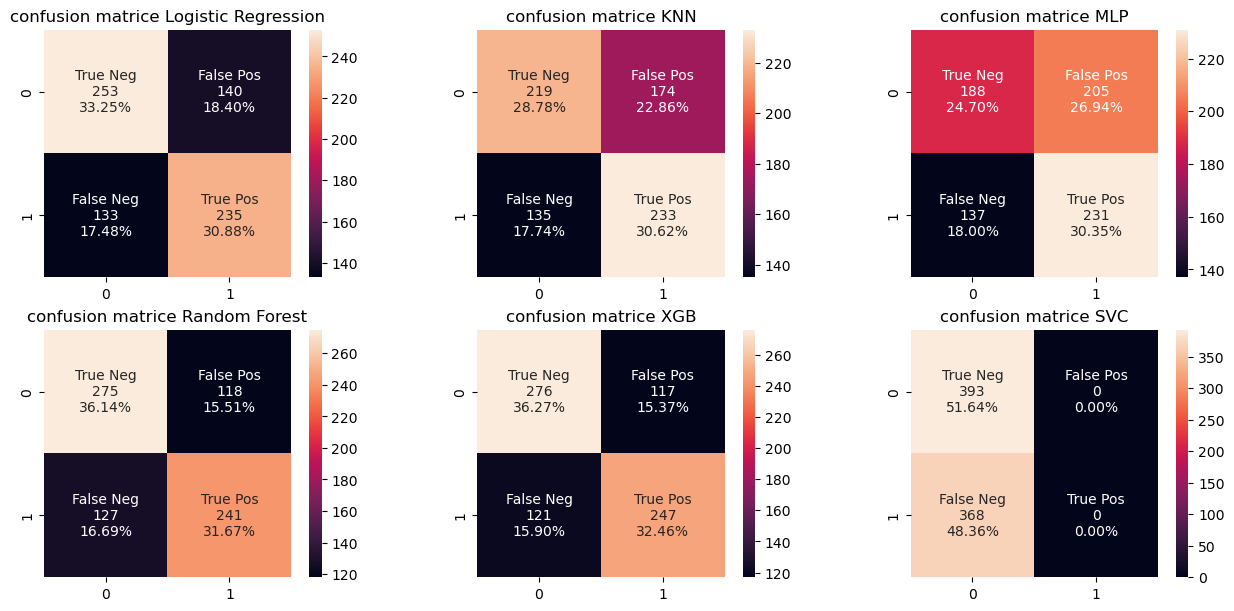

In [16]:
results_df=resultats(root_directory, filename_ecg, filename_rr, filename_eda, filename_label, )
results_df

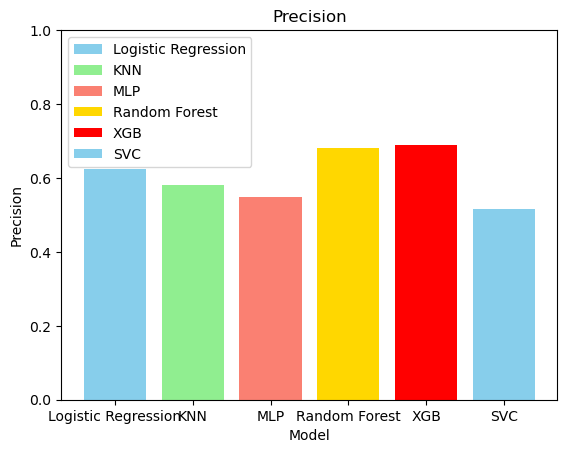

In [10]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'red']
plt.bar(results_df['Model'], results_df['Mean accuracy'], label=results_df['Model'], color=colors)
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision')
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

In [14]:
results_df.to_csv(r'C:\Users\leagi\Documents\EI22\Projet Ecole\ECG\parameters.csv',sep=';', index=False)

################################################################################################

In [36]:
features = read_feature_dataset(root_directory, filename_ecg, filename_rr, filename_eda, filename_label)
#features

In [37]:
# Replacing infinite with nan
features.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
features.dropna(inplace=True)

In [38]:
inputs = features.drop('Stress',axis=1)
target = features['Stress']

In [39]:
x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.2,random_state=42)

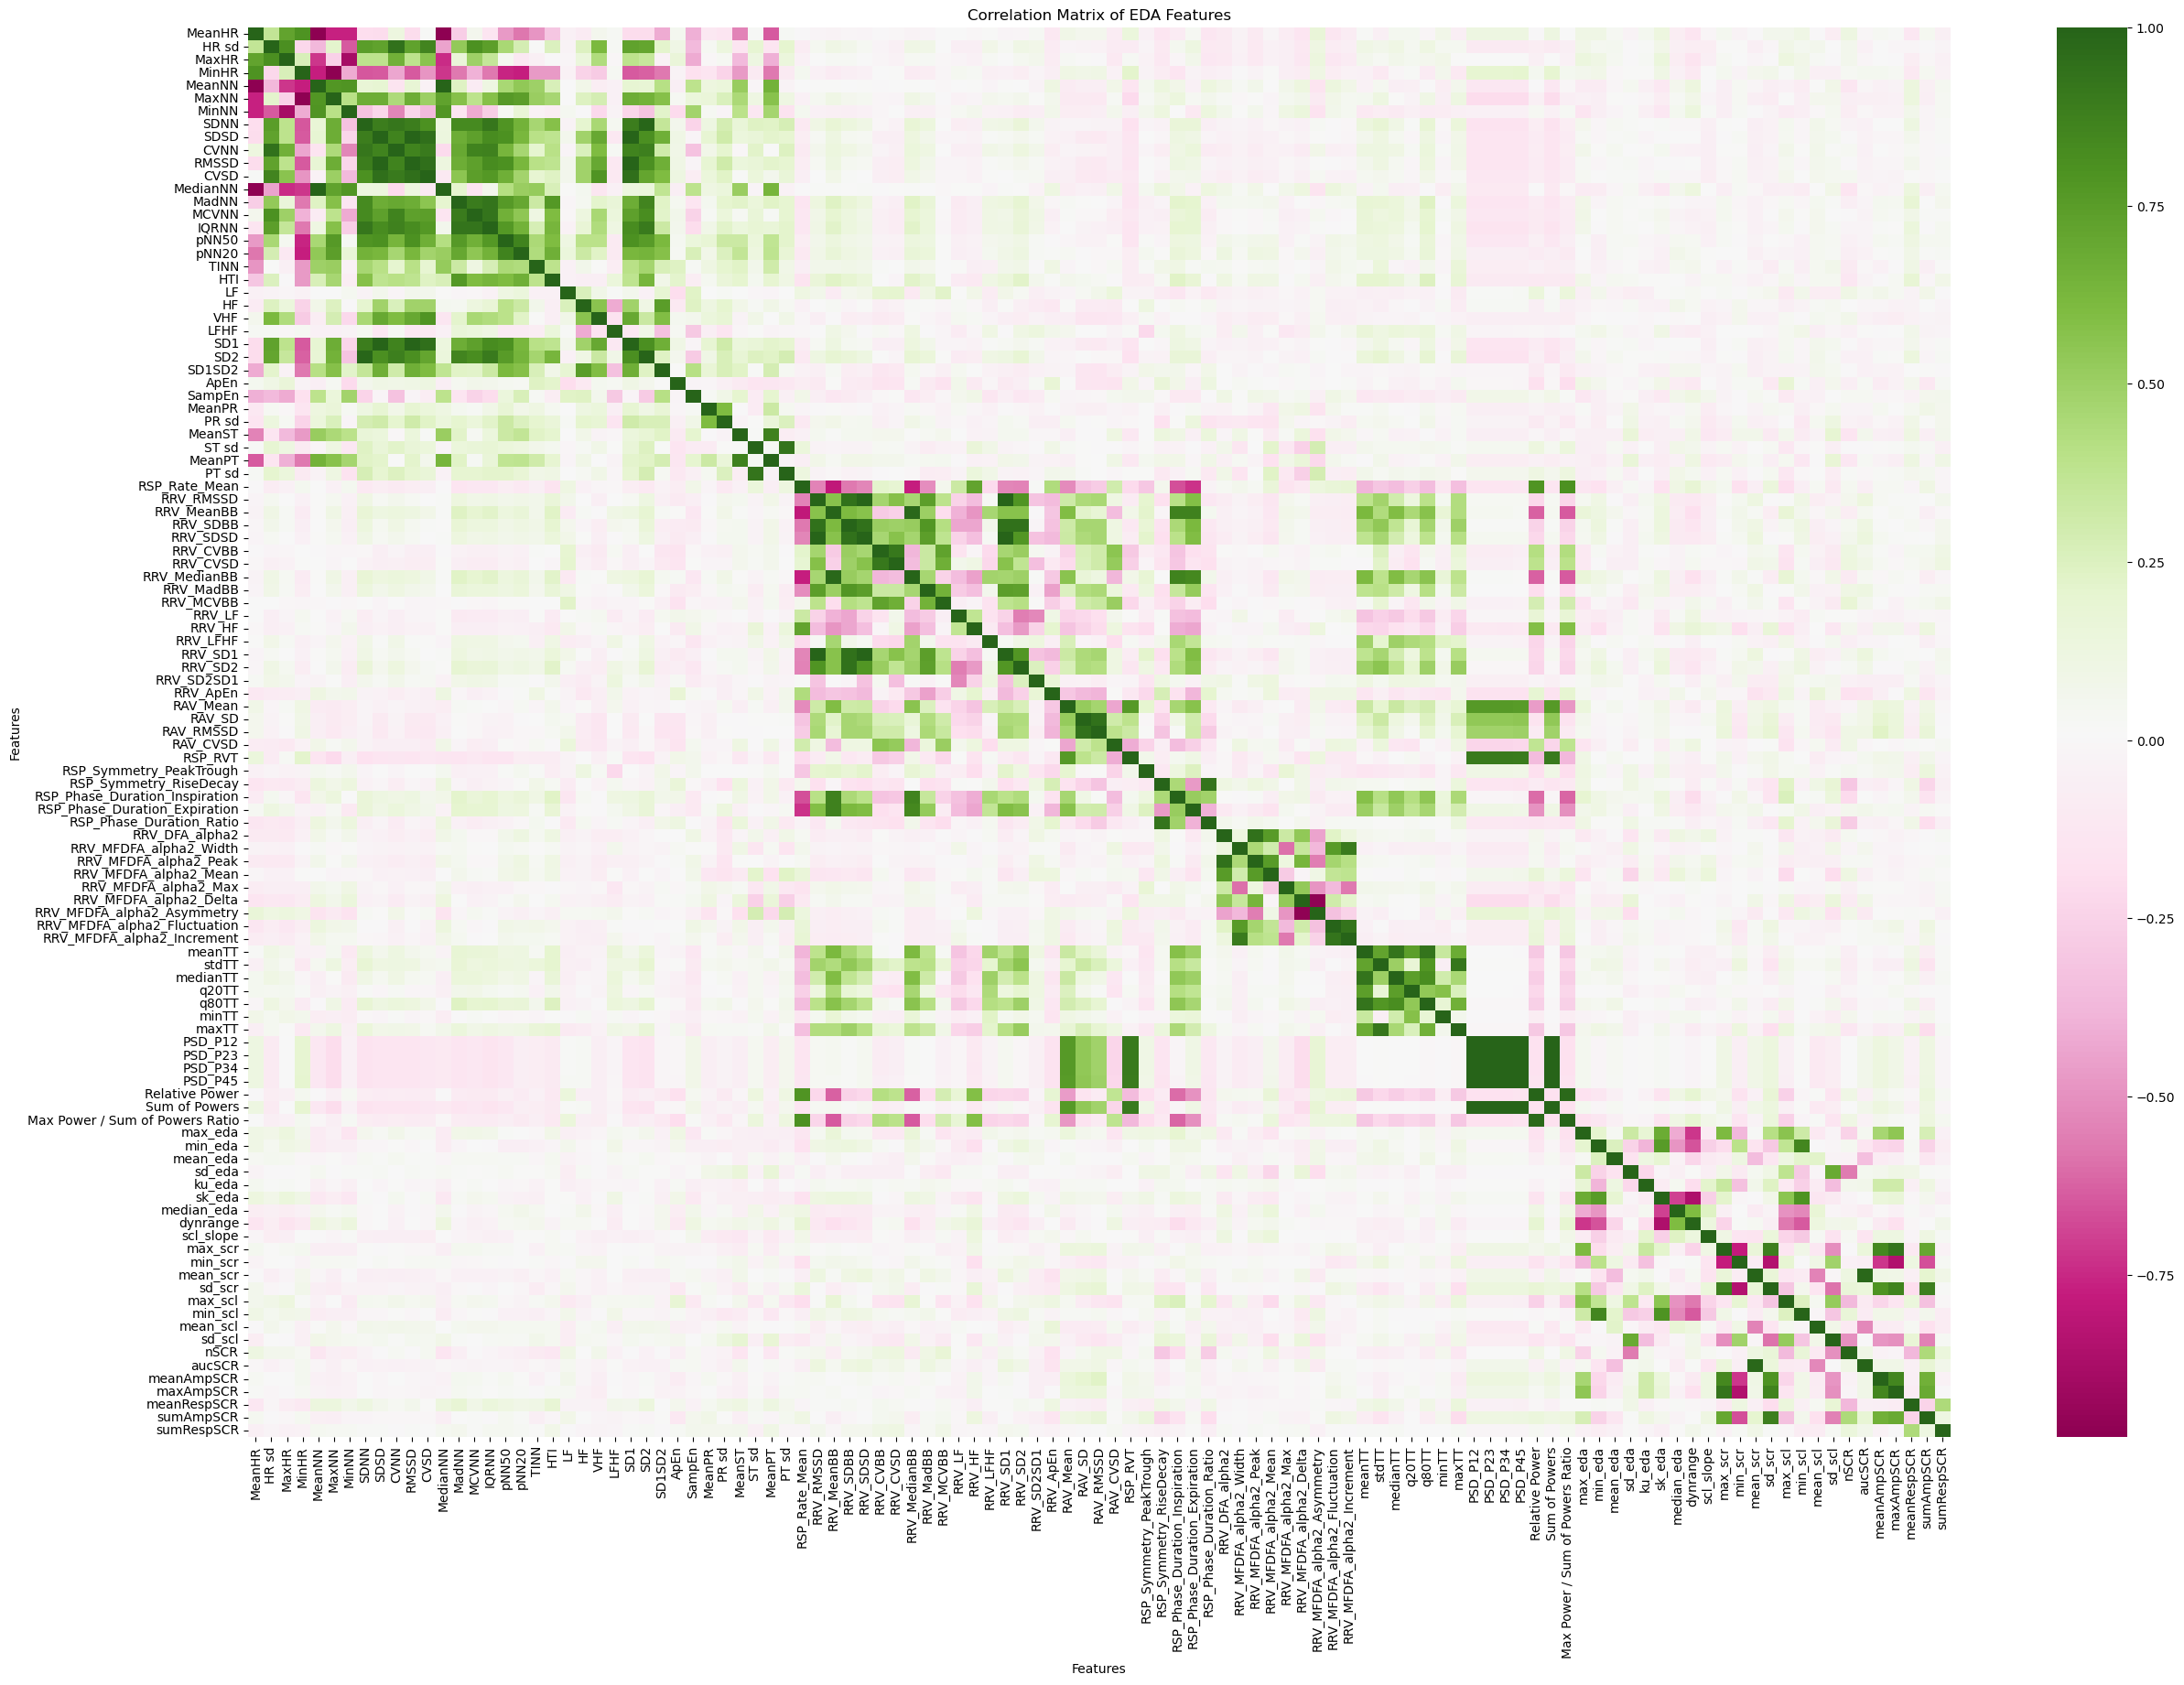

In [40]:
# Calculate the correlation matrix
#correlation_matrix = features.corr()
correlation_matrix = x_train.corr()

# Create a heatmap
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=False, fmt='.0f', annot_kws=dict(size=15), cmap='PiYG')
plt.title('Correlation Matrix of EDA Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [41]:
def highlight_corr(values):
    color = 'red' if values >=0.9 else ''
    return f'background-color: {color}'
highlighted_corr = correlation_matrix.style.applymap(highlight_corr)
#highlighted_corr

In [42]:
#selection des motifs avec la matrice de correlation
corr_pairs=[]
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i,j]>0.9:
            corr_pairs.append((correlation_matrix.columns[i],correlation_matrix.columns[j],correlation_matrix.iloc[i,j]))
corr_pairs

[('CVNN', 'HR sd', 0.945825565400925),
 ('CVNN', 'SDNN', 0.9158096518088251),
 ('RMSSD', 'SDSD', 0.9999964942460755),
 ('CVSD', 'SDSD', 0.9492491865209902),
 ('CVSD', 'CVNN', 0.9048028099595206),
 ('CVSD', 'RMSSD', 0.9492991046841949),
 ('MedianNN', 'MeanNN', 0.993283173028934),
 ('IQRNN', 'SDNN', 0.9179989668776027),
 ('IQRNN', 'MadNN', 0.9249302428169555),
 ('IQRNN', 'MCVNN', 0.9242934492238708),
 ('SD1', 'SDSD', 0.9999999999999997),
 ('SD1', 'RMSSD', 0.999996494246075),
 ('SD1', 'CVSD', 0.9492491865209888),
 ('SD2', 'SDNN', 0.9870046360758283),
 ('SD2', 'IQRNN', 0.9056738981638477),
 ('PT sd', 'ST sd', 0.9296302314337079),
 ('RRV_SDBB', 'RRV_RMSSD', 0.945016671896864),
 ('RRV_SDSD', 'RRV_RMSSD', 0.9993209930110749),
 ('RRV_SDSD', 'RRV_SDBB', 0.9413150214695413),
 ('RRV_CVSD', 'RRV_CVBB', 0.9108095919086538),
 ('RRV_MedianBB', 'RRV_MeanBB', 0.978452609424728),
 ('RRV_SD1', 'RRV_RMSSD', 0.9993209930110749),
 ('RRV_SD1', 'RRV_SDBB', 0.9413150214695418),
 ('RRV_SD1', 'RRV_SDSD', 0.99999

In [43]:
features_to_drop = []
for i,j,k in corr_pairs:
    features_to_drop.append(j)
    
features_to_drop = list(set(features_to_drop))
features_to_drop

['RSP_RVT',
 'RRV_MFDFA_alpha2_Fluctuation',
 'PSD_P34',
 'meanTT',
 'RRV_SDSD',
 'SDSD',
 'PSD_P12',
 'HR sd',
 'PSD_P45',
 'SDNN',
 'PSD_P23',
 'MCVNN',
 'RRV_RMSSD',
 'stdTT',
 'Relative Power',
 'MadNN',
 'RRV_MeanBB',
 'RAV_SD',
 'MeanNN',
 'RRV_SDBB',
 'RSP_Symmetry_RiseDecay',
 'RRV_CVBB',
 'ST sd',
 'IQRNN',
 'CVSD',
 'max_scr',
 'RRV_DFA_alpha2',
 'CVNN',
 'mean_scr',
 'RMSSD']

In [44]:
x_train_selected = x_train.drop(features_to_drop,axis=1)
x_test_selected = x_test.drop(features_to_drop,axis=1)

In [45]:
#modele avec tous les motifs
logit = RandomForestClassifier()
logit.fit(x_train,y_train)
prediction = logit.predict(x_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71        82
         1.0       0.67      0.68      0.67        71

    accuracy                           0.69       153
   macro avg       0.69      0.69      0.69       153
weighted avg       0.69      0.69      0.69       153



In [46]:
#modele avec la selection des motifs
logitSelected = RandomForestClassifier()
logitSelected.fit(x_train_selected,y_train)
predSelected = logitSelected.predict(x_test_selected)
print(classification_report(y_test,predSelected))

              precision    recall  f1-score   support

         0.0       0.68      0.71      0.69        82
         1.0       0.65      0.62      0.63        71

    accuracy                           0.67       153
   macro avg       0.66      0.66      0.66       153
weighted avg       0.67      0.67      0.67       153



In [96]:
def resultats_ancien(root_directory, feature_ecg, feature_rr, feature_eda, label):
    features = read_feature_dataset(root_directory, feature_ecg, feature_rr, feature_eda, label)
    
    # Remove infinite values
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.dropna(inplace=True)

    # data's separation
    inputs = features.drop('Stress',axis=1)
    target = features['Stress']
    x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.2,random_state=42)

    corr_matrix = correlation_matrix(x_train)

    #features selection
    features_to_drop = features_selection(corr_matrix)

    x_train_selected = x_train.drop(features_to_drop,axis=1)
    x_test_selected = x_test.drop(features_to_drop,axis=1)

    # prediction table with all features
    prediction_all = []
    # prediction table with features selected
    prediction_sel = []

    for i in tqdm(range(20)):
        #all features
        logit = RandomForestClassifier(bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100)
        logit.fit(x_train,y_train)
        prediction = logit.predict(x_test)
        prediction_all.append(classification_report(y_test,prediction, output_dict=True)['accuracy'])

        #features selected
        logitSelected = RandomForestClassifier(bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100)
        logitSelected.fit(x_train_selected,y_train)
        predSelected = logitSelected.predict(x_test_selected)
        prediction_sel.append(classification_report(y_test,predSelected, output_dict=True)['accuracy'])

    
    moyenne_all = moyenne(prediction_all)*100
    moyenne_sel = moyenne(prediction_sel)*100

    
    conf_matrix_all = confusion_matrix(y_test, prediction)
    conf_matrix_sel = confusion_matrix(y_test, predSelected)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6)) 
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix_all.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix_all.flatten()/np.sum(conf_matrix_all)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix_all, annot=labels, fmt='', ax=axes[0])
    axes[0].set_title('without selection- Random Forest')

    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix_sel.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix_sel.flatten()/np.sum(conf_matrix_sel)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix_sel, annot=labels, fmt='', ax=axes[1])
    axes[1].set_title('with selection - Random Forest')

    print("\nLes résultats sont en d'en moyenne " + str(round(moyenne_all,2)) + "% sans la selection des motifs et " + str(round(moyenne_sel,2)) + "% avec la selection\n")
    
    return moyenne_all, moyenne_sel

In [ ]:
mean_all, mean_sel = resultats_ancien(root_directory, filename_ecg, filename_rr, filename_eda, filename_label)

In [94]:
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=200),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs']
            }
        },
        'k-Nearest Neighbors': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
        },

        'MLP Classifier': {
            'model': MLPClassifier(max_iter=1000),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (50, 50)],
                'activation': ['tanh', 'relu'],
                'solver': ['sgd', 'adam'],
                'alpha': [0.0001, 0.05],
                'learning_rate': ['constant', 'adaptive']
            }
        },
        
        'Support Vector Machine': {
            'model': SVC(),
            'params': {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto']
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [10, 50, 100],
                'max_depth': [None, 5, 10],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
            'params': {
                'n_estimators': [50, 100, 200],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 5, 7],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            }
        }

SyntaxError: illegal target for annotation (3736317875.py, line 1)